# Klasifikasi Retakan Permukaan Beton Guna Dalam Pemeliharaan Infrastruktur

## Import Library

In [17]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Load Gambar

In [18]:
data = []
labels = []
file_name = []

# Tentukan 3 label folder yang ingin dimuat
allowed_labels = ['label1', 'label2', 'label3']

# Loop hanya pada folder yang termasuk dalam allowed_labels
for sub_folder in os.listdir("dataset\\"):
    if sub_folder not in allowed_labels:
        continue  # Lewati folder yang tidak termasuk

    sub_folder_path = os.path.join("dataset\\", sub_folder)
    sub_folder_files = os.listdir(sub_folder_path)

    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        if img is None:
            continue  # Lewati file yang gagal dibaca

        img = img.astype(np.uint8)
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)
        
print(f"Total gambar berhasil dimuat: {len(data)}")
print(f"Total label yang dimuat: {len(labels)}")


data = np.array(data)
labels = np.array(labels)

Total gambar berhasil dimuat: 600
Total label yang dimuat: 600


## Data Understanding

### Distribusi Data per Label

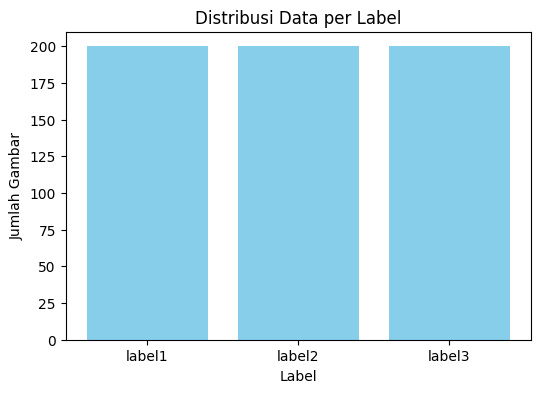

Label: label1, Jumlah: 200
Label: label2, Jumlah: 200
Label: label3, Jumlah: 200


In [ ]:
# 1. Distribusi Data per Label
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(unique, counts, color='skyblue')
plt.title("Distribusi Data per Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.show()

for u, c in zip(unique, counts):
    print(f"Label: {u}, Jumlah: {c}")

### Menampilkan Sampel Data dari Setiap Label

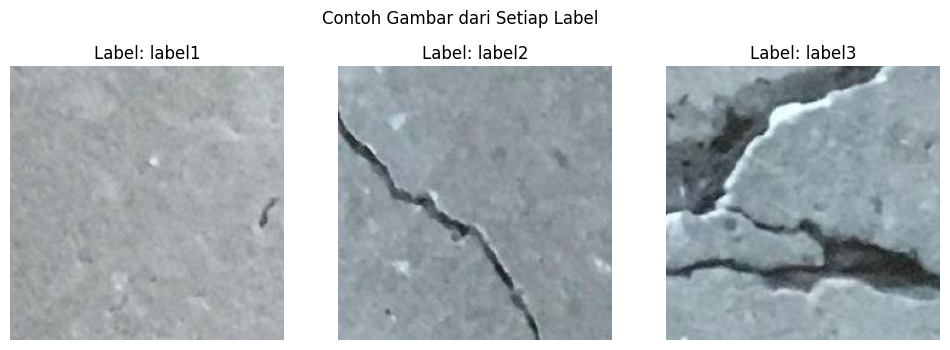

In [20]:
# 2. Menampilkan Sampel Data dari Setiap Label
plt.figure(figsize=(12,4))
for idx, label in enumerate(unique):
    idx_sample = np.where(labels == label)[0][0]
    plt.subplot(1, len(unique), idx+1)
    plt.imshow(data[idx_sample], cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.suptitle("Contoh Gambar dari Setiap Label")
plt.show()

### Statistik Dasar dari Gambar

In [21]:
# 3. Statistik Dasar Gambar
print("Ukuran gambar:", data[0].shape)
print("Nilai pixel min:", np.min(data), "max:", np.max(data), "mean:", np.mean(data))

Ukuran gambar: (227, 227, 3)
Nilai pixel min: 0 max: 255 mean: 166.0229590780596


### Distribusi Brightness Gambar

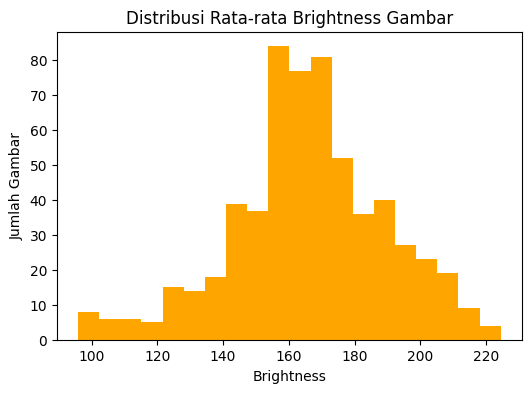

In [22]:
# 4. Distribusi Brightness
brightness = [np.mean(img) for img in data]
plt.figure(figsize=(6,4))
plt.hist(brightness, bins=20, color='orange')
plt.title("Distribusi Rata-rata Brightness Gambar")
plt.xlabel("Brightness")
plt.ylabel("Jumlah Gambar")
plt.show()

## Data Preparation

### Menentukan Function Preprocessing

In [ ]:
def grayscaling_manual(img):
    b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.114 * b + 0.587 * g + 0.299 * r
    return gray.astype(np.uint8)

# data_gray = np.array([grayscaling_manual(img) for img in data])

def ekualisasi_hist_manual(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')
    img_eq = cdf_final[img_gray]
    return img_eq

# data_eq = np.array([ekualisasi_hist_manual(img) for img in data_gray])

def median_filter_manual(img, size=3):
    pad = size // 2
    img_padded = np.pad(img, pad, mode='edge')
    img_median = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = img_padded[i:i+size, j:j+size]
            img_median[i, j] = np.median(region)
    return img_median.astype(np.uint8)

In [28]:
dataPreprocessed = []
for i in range(len(data)):
    img = data[i]
    img_gray = grayscaling_manual(img)
    img_eq = ekualisasi_hist_manual(img_gray)
    img_med = median_filter_manual(img_eq)
    dataPreprocessed.append(img_med)

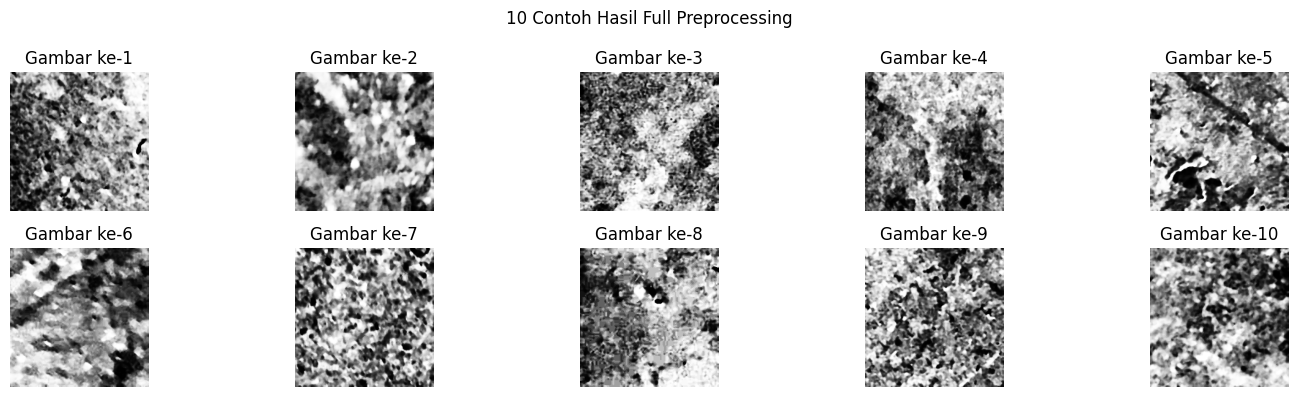

In [29]:
plt.figure(figsize=(15, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(dataPreprocessed[i], cmap='gray')
    plt.title(f"Gambar ke-{i+1}")
    plt.axis('off')
plt.suptitle("10 Contoh Hasil Full Preprocessing")
plt.tight_layout()
plt.show()

## Feature Extraction

In [30]:
def glcm(img, derajat):
    if derajat == 0:
        angle = [0]
    elif derajat == 45:
        angle = [np.pi/4]
    elif derajat == 90:
        angle = [np.pi/2]
    elif derajat == 135:
        angle = [3*np.pi/4]
    else:
        raise ValueError("Derajat harus 0, 45, 90, atau 135")
    
    glcm_matrix = graycomatrix(img, [1], angle, 256, symmetric=True, normed=True)
    return glcm_matrix

In [31]:
def correlation(matrix):
    return graycoprops(matrix, 'correlation')[0, 0]
def dissimilarity(matrix):
    return graycoprops(matrix, 'dissimilarity')[0, 0]
def homogeneity(matrix):
    return graycoprops(matrix, 'homogeneity')[0, 0]
def contrast(matrix):
    return graycoprops(matrix, 'contrast')[0, 0]
def ASM(matrix):
    return graycoprops(matrix, 'ASM')[0, 0]
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]
def entropyGLCM(matrix):
    return entropy(matrix.ravel())

In [32]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [34]:
corr0, corr45, corr90, corr135 = [], [], [], []
diss0, diss45, diss90, diss135 =  [], [], [], []
homo0, homo45, homo90, homo135 = [], [], [], []
Kon0, Kon45, Kon90, Kon135 = [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
entr0, entr45, entr90, entr135 =  [], [], [], []

In [ ]:
for i in range(len(dataPreprocessed)):
    # Sudut 0
    D0 = Derajat0[i]
    Kon0.append(contrast(D0))
    diss0.append(dissimilarity(D0))
    homo0.append(homogeneity(D0))
    entr0.append(entropyGLCM(D0))
    ASM0.append(ASM(D0))
    energy0.append(energy(D0))
    corr0.append(correlation(D0))

In [ ]:
for i in range(len(dataPreprocessed)):
    # Sudut 45
    D45 = Derajat45[i]
    Kon45.append(contrast(D45))
    diss45.append(dissimilarity(D45))
    homo45.append(homogeneity(D45))
    entr45.append(entropyGLCM(D45))
    ASM45.append(ASM(D45))
    energy0.append(energy(D0))
    corr0.append(correlation(D0))

In [ ]:
for i in range(len(dataPreprocessed)):
    # Sudut 90
    D90 = Derajat90[i]
    Kon90.append(contrast(D90))
    diss90.append(dissimilarity(D90))
    homo90.append(homogeneity(D90))
    entr90.append(entropyGLCM(D90))
    ASM90.append(ASM(D90))
    energy90.append(energy(D90))
    corr90.append(correlation(D90))

In [ ]:
for i in range(len(dataPreprocessed)):
    # Sudut 135
    D135 = Derajat135[i]
    Kon135.append(contrast(D135))
    diss135.append(dissimilarity(D135))
    homo135.append(homogeneity(D135))
    entr135.append(entropyGLCM(D135))
    ASM135.append(ASM(D135))
    energy135.append(energy(D135))
    corr135.append(correlation(D135))